In [50]:
import pandas as pd
import numpy as np
from ipynb.fs.full.AQP_system import AQP_system
from ipynb.fs.full.GK_summary import GK_summary, GK_quantile
import math
import matplotlib.pyplot as plt

In [29]:
data = pd.read_table('data/lineitem_clean.csv', header = 0, sep = ',')

In [33]:
data = data.sample(n=10000)

In [ ]:
#data = data.set_index("ORDERKEY", drop = False)

In [ ]:
#Read data
#data = pd.read_csv('data/tpch_100000.csv')

In [51]:
#create system class
class AQP_system:
    #****System Parameters****
    
   
    #numeric columns
    #numeric_columns = []
    #categorical columns
    #categorical_columns = []
    #total allowed space (proportion of underlying data)
    #total_allowed_space = None
    #remaining space (used when initializing meetadata0)
    #remaining_space = None
    #max quantile rank error
    #quantile_error = None
    #histogram min number of buckets (power of nrows in data)
    #histogram_min_size = None
    #max sample+seek distribution error
    #sample_error = None
    #indicator to use stdev-weighred sample sizes
    #stdev_option = False
    #indicator to use column storage in measure biased samples only for predicate columns correlated to the measure
    #correlated_column_storage_option = False
    #indicator to store selectivites of each categorical variable in each sample table or not
    #column_selectivity_map_option = False
    #indicator to allocate extra space (above minimum needed to guaruntee GK and sample+seek errors) to histograms/samples 
    #based on a-priori knowledge of the query workload or not)
    #know_queries_in_advance = False
    #workload of queries
    #workload = []
    #uniform
    #include uniform sample for count or not
   
    
    #****System Metadata****
    #nrows data
    #N = None
    #GK_summaries_map = {}
    #stdev_map = {}
    #uniform_sample = None
    #uniform_sample_selectivity_map = {}
    #correlated_columns_for_samples_map = {}
    #min_rows_sample_table = None
    #histogram_map = {}
    #measure_biased_samples_map = {}
    #measure_biased_samples_selectivity_map = {}
    
    
    
    #init
    def __init__(self, data, numeric_columns, categorical_columns, total_allowed_space, histogram_min_size=None, quantile_error=None, sample_error=None, uniform=False,stdev_option=False, 
                correlated_column_storage_option=False, column_selectivity_map_option=False, know_queries_in_advance=False, workload=None):
        
        #initialize required parameters
        self.N = data.shape[0]
        self.numeric_columns = numeric_columns;
        self.categorical_columns = categorical_columns;
        self.total_allowed_space = total_allowed_space
        
        #note: changing space away from proportion to number of entries
        print ("Total Size" + str(data.shape[0]*data.shape[1]))
        self.remaining_space = data.shape[0]*data.shape[1]*total_allowed_space
        print ("Remaining Space" + str(self.remaining_space))
        
        #initialize optional parameters
            
        self.know_queries_in_advance = False;
        if (know_queries_in_advance):
            self.know_queries_in_advance = know_queries_in_advance
            self.workload = workload
        
        #initialize metadata
        self.measure_biased_samples_map = {}
        
        if (quantile_error!=None):
            self.GK_summaries_map = {}
            self.quantile_error = quantile_error
            self.initialize_GK_summaries(data);
            self.remaining_space = self.remaining_space-self.get_GK_size()
        
        self.stdev_option = stdev_option
        if (stdev_option): 
            self.initialize_stdev_map (data)
            self.remaining_space = self.remaining_space-len(stdev_map.values())
        
        #no space addition, should get deleted after initialization
        self.correlated_column_storage_option = correlated_column_storage_option
        if(correlated_column_storage_option): 
            self.initialize_correlated_columns_for_samples_map (data)
            self.remaining_space = self.remaining_space-len(correlated_columns_for_samples_map.values())
        
        if (sample_error != None):
            self.sample_error = sample_error
            self.min_rows_sample_table = math.sqrt(self.N)
            self.min_rows_sample_table =self.min_rows_sample_table/(self.sample_error)**2
            self.min_rows_sample_table=int(self.min_rows_sample_table)
            self.min_sample_size = self.get_min_sample_size(N=data.shape[0], data=data)
            self.remaining_space = self.remaining_space - self.min_sample_size
        
        if (histogram_min_size != None):
            self.histogram_map = {}
            self.histogram_min_size = histogram_min_size
            min_histogram_size = (data.shape[0]*histogram_min_size)*len(self.numeric_columns)
            self.remaining_space = self.remaining_space - min_histogram_size
            
        remaining_space_distribution = self.get_remaining_space_distribution();
        
        if (histogram_min_size != None):
            self.histogram_total_space = min_histogram_size + remaining_space_distribution['Range']*self.remaining_space
            self.initialize_histograms(data, self.histogram_total_space)
        
        if (sample_error != None):
            measure_biased_samples_extra_space = remaining_space_distribution['Sum+Predicate']*self.remaining_space
            self.measure_biased_samples_space= self.min_sample_size + measure_biased_samples_extra_space
            self.initialize_measure_biased_samples (data, measure_biased_samples_extra_space)
        
        if (uniform):
            uniform_sample_extra_space = remaining_space_distribution['Count']*self.remaining_space
            self.initialize_uniform_sample(data, uniform_sample_extra_space)
            
        if (column_selectivity_map_option): 
            self.column_selectivity_map_option = column_selectivity_map_option
            self.initialize_measure_biased_samples_selectivity_map()
            self.initialize_uniform_sample_selectivity_map (data)
    

    #Initializes all metada for the system to process queries on the underlying data
    def initialize_GK_summaries(self, data):
        for column in self.numeric_columns:
            summary = GK_summary (data[column].to_numpy(), self.quantile_error)
            self.GK_summaries_map[column] = summary
    
    #this is public also
    def get_GK_size(self):
        total_size = 0
        for key in self.GK_summaries_map:
            summary = self.GK_summaries_map[key]
            total_size+=len(summary)
        #*3 for tuples
        return total_size*3
    
    def get_histogram_size(self):
        return self.histogram_total_space
    
    def get_measure_biased_samples_size(self):
        total_size_sample = 0
        for key in self.measure_biased_samples_map:
            sample = self.measure_biased_samples_map[key]
            total_size_sample += sample.shape[0]*sample.shape[1]
        return total_size_sample
    
    def initialize_stdev_map (self, data):
        for column in self.numeric_columns:
            self.stdev_map[column] = np.std(data[column])
    
    def initialize_uniform_sample (self, data, extra_space):
        extra_rows = int(extra_space/data.shape[1])
        #minimum size needed for error gauruntee (sample+seek)
        self.uniform_sample = data.sample(n=self.min_rows_sample_table + extra_rows)
        
    def initialize_uniform_sample_selectivity_map (self, data):
        for column in self.categorical_columns:
            frequency_map = {}
            for entry in self.uniform_sample[column]:
                if (entry in frequency_map):
                    frequency_map[entry] = frequency_map[entry] + 1
                else:
                    frequency_map[entry] = 1
            self.uniform_sample_selectivity_map[column]=frequency_map
            
    def initialize_correlated_columns_for_samples_maps (self, data):
        for num_column in self.numeric_columns:
            correlated_columns_for_samples_map[num_colum] = []
            for cat_column in self.categorical_columns:
                ols_formula = num_column + ' ~ ' +'C(' + cat_column + ')'
                model = ols(ols_formula, data=self.uniform_sample).fit()
                aov_table = sm.stats.anova_lm(model, typ=2)
                p_value=aov_table['PR(>F)']['C(' + cat_column + ')']
                if (p_value<=.05):
                    correlated_columns_for_samples_map[num_colum].append(cat_column)
                    
    def get_min_sample_size (self, N, data):
        sample_size = 0
        #categorical columns in samples
        if (self.correlated_column_storage_option):
            for key in self.correlated_columns_for_samples_map:
                val = self.correlated_columns_for_samples_map[key]
                sample_size += len(val)*self.min_rows_sample_table
        else:
            sample_size += self.min_rows_sample_table*len(self.categorical_columns)**len(self.numeric_columns)
        return sample_size/(data.shape[0]*data.shape[1])
    
    def get_remaining_space_distribution(self):
        if (self.know_queries_in_advance):
            #count workload frequency
            workload_frequency_map = {'Sum+Predicate':0, 'Range':0, 'Count':0}
            total = 0
            for query in self.workload:
                if (query == 'Sum+Predicate' or query =='Range'  or query == 'Count'):
                    workload_frequency_map[query] += 1
                    total += 1
            #normalize to a distribution
            for key in workload_frequency_map:
                workload_frequency_map[key] = workload_frequency_map[key]/total
                workload_frequency_map[key] = workload_frequency_map[key]*self.remaining_space
            return workload_frequency_map
        else:
            #for now, do nto allocate extra space
            return {'Sum+Predicate': 0, 'Range': 0, 'Count': 0}
    
    def initialize_histograms (self, data, total_space):
        #calculate number of buckets
        num_bins = int(total_space);
        
        #initialize histogram
        for column in self.numeric_columns:
            measure_column = data[column].to_numpy()
            self.histogram_map[column] = np.histogram(measure_column, bins=num_bins)
            
    def initialize_measure_biased_samples (self, data, extra_space):
            #used for stdev setting
            if (self.stdev_option):
                total_stdev = sum(self.stdev_map.values())
             
            data_c = data.copy();
            for column in self.numeric_columns:
                #drop uncorrelated columns
                if (self.correlated_column_storage_option):
                    columns_to_drop = list(set(self.categorical_columns)-set(correlated_columns_for_samples_map[column]))
                    data_c = data_c.drop(columns_to_drop)
                    
                measure_column = data_c[column].to_numpy()
                sample_probabilities = measure_column
                sample_probabilities = sample_probabilities/np.sum(sample_probabilities)
                sample_table = None
                if (self.stdev_option):
                    nrow_stdev_option_proportion = stdev_map[column]/total_stdev

                    #total extra rows * proportion
                    n_rows_extra =  int(extra_space/data_c.shape[1])*nrow_stdev_option_proportion

                    sample_table = data_c.sample(n = self.min_rows_sample_table+n_rows_extra, replace=True, weights= sample_probabilities)
                    self.measure_biased_samples_map[column] = sample_table
                else:
                    #total number of rows/numbers of tables
                    n_rows_extra =  int(extra_space/data_c.shape[1]/len(numeric_columns))
                    sample_table = data_c.sample(n = self.min_rows_sample_table+n_rows_extra, replace=True, weights= sample_probabilities)
                    self.measure_biased_samples_map[column] = sample_table
    
    def initialize_measure_biased_samples_selectivity_map (self):
        for key in self.measure_biased_samples_map:
            sample = self.measure_biased_samples_map[key]
            column_map = {}
            columns_to_use = self.categorical_columns
            if (correlated_column_storage_option):
                columns_to_use = correlated_columns_for_samples_map [key]
            for column in sample.columns:
                frequency_map = {}
                for entry in sample[column]:
                    if (entry in frequency_map):
                        frequency_map[entry] = frequency_map[entry] + 1
                    else:
                        frequency_map[entry] = 1
                column_map[column]=frequency_map
            self.measure_biased_speedup_map[key] = column_map
    #Public:
    
    def approximate_query (self,query):
        query_type = query[0];
        if (query_type == 'Quantile'):
            column = query[1];
            quantile = query[2];
            
            summary = self.GK_summaries_map[column];
            estimate = GK_quantile (summary, self.quantile_error, quantile, self.N)
            return estimate
        #find proporiton of elements greater thana . valu
        elif (query_type  == "Range"):
            column = query[1];
            value = query[2];

            hist = self.histogram_map[column]
            elements = hist[0]
            buckets = hist[1]
            sum_index = 0
            max_error = 0
            for j in range (1,len(buckets)):
                if (buckets[j]>=value):
                    sum_index = j
                    max_error = elements[j-1]
                    break

            sum_buckets = 0
            for k in range (len(elements)):
                if (k>=(sum_index-1)):
                    sum_buckets += elements[k]
            estimate = sum_buckets;
            return [estimate, max_error]
        elif (query_type == "Sum+Predicate"):
            numeric = query[1]
            categorical = query[2]
            sample = self.measure_biased_samples_map [numeric]
            estimated_distribution = {}
            total = 0
            for predicate in sample[categorical]:
                if (predicate not in estimated_distribution):
                    estimated_distribution[predicate] = 1
                else:  
                    estimated_distribution[predicate] += 1
                total += 1
            for key in estimated_distribution:
                estimated_distribution[key] /= total
            return estimated_distribution

In [52]:
#full data parameters
#numeric_columns = ['L_QUANTITY', 'L_EXTENDEDPRICE', 'L_DISCOUNT', 'L_TAX', 'C_ACCTBAL', 'O_TOTALPRICE', 'P_SIZE', 
                     #'#P_RETAILPRICE', 'PS_AVAILQTY', 'PS_SUPPLYCOST', 'S_ACCTBAL']

#categorical_columns = ['L_ORDERKEY', 'L_PARTKEY', 'L_SUPPKEY', 'L_LINENUMBER', 'L_RETURNFLAG', 
                       #'L_LINESTATUS', 'L_SHIPDATE', 'L_COMMITDATE', 'L_RECEIPTDATE', 'L_SHIPINSTRUCT', 
                       #'L_SHIPMODE', 'C_CUSTKEY', 'C_NAME', 'C_ADDRESS', 'C_NATIONKEY', 'C_PHONE', 
                       #'C_MKTSEGMENT', 'O_ORDERKEY', 'O_CUSTKEY', 'O_ORDERSTATUS', 'O_ORDERDATE', 
                       #'O_ORDERPRIORITY', 'O_CLERK', 'O_SHIPPRIORITY', 'P_PARTKEY', 'P_NAME', 'P_MFGR', 
                       #'P_BRAND', 'P_TYPE', 'P_CONTAINER', 'PS_PARTKEY', 'PS_SUPPKEY', 'S_SUPPKEY', 'S_NAME', 
                       #'S_ADDRESS', 'S_NATIONKEY', 'S_PHONE', 'N1_NATIONKEY', 'N1_NAME', 'N1_REGIONKEY', 
                       #'N2_NATIONKEY', 'N2_NAME', 'N2_REGIONKEY', 'R1_REGIONKEY', 'R1_NAME', 'R2_REGIONKEY', 
                       #'R2_NAME']

In [53]:
#lineitem parameters
numeric_columns = ['LINENUMBER', 'QUANTITY', 'EXTENDEDPRICE', 'DISCOUNT', 
                               'TAX']
categorical_columns = ['RETURNFLAG', 'LINESTATUS', 'SHIPINSTRUCT', 'SHIPMODE']

In [ ]:
#Evaluation 1.1: GK alon


In [ ]:
#create one system to evaluate quantiles
total_allowed_space = .1
quantile_error = .25
system_1 = AQP_system(data, numeric_columns, categorical_columns, total_allowed_space, quantile_error=quantile_error)

In [ ]:
system_1 = AQP_system(data, numeric_columns, categorical_columns, total_allowed_space, quantile_error=quantile_error)

In [ ]:
#create a query
quantile = .5
column = 'LINENUMBER'
query = ['Range', column, quantile]
#estimate that query
estimate = system_1.approximate_query(query)
print (estimate)

In [54]:
#get sorted columns for error
data_copy = data.copy()
sorted_columns = {}
for column in numeric_columns:
   cur_column = data_copy[column]
   cur_column = cur_column.to_numpy()
   cur_column.sort()
   sorted_columns [column] = cur_column

In [55]:
#Test on a range of examples:
#error and size for various user e
total_allowed_space = .1
n_examples = 100
columns_to_test = np.random.choice (numeric_columns, n_examples, replace = True)
quantile = .5
errors = [.05, .1, .2, .25]
results_map = {}
for e in errors:
    total_error = 0
    system_1 = AQP_system(data, numeric_columns, categorical_columns, total_allowed_space, quantile_error=e)
    #maps error level to (size, total error)
    results_map[e]=[system_1.get_GK_size(), 0]
    print ("Built system for error " + str(quantile_error))
    for i in range (n_examples):
        print ("Example " + str(i))
        column = columns_to_test[i]
        query = ['Quantile', column, quantile]
        
        #estimate that query
        estimate = system_1.approximate_query(query)
        sorted_column = sorted_columns[column]
        
        #find ranks of estimate 
        estimate_ranks = []
        for i in range (len(sorted_column)):
            if (sorted_column[i]==estimate):
                estimate_ranks.append(i)
            
        if (len(estimate_ranks) == 0):
            estimate_ranks = [len(sorted_column)]
        
        #find the smallest distance between an estimate rank and the actual rank, calculate rank error
        errors = []
        for entry in estimate_ranks:
            errors.append(abs(entry - quantile*len(sorted_column))/len(sorted_column))
        total_error += np.amin (errors)
    results_map[e][1] = total_error/(n_examples)
        

Total Size160000
Remaining Space16000.0
Built system for error 0.25
Example 0
Example 1
Example 2
Example 3
Example 4
Example 5
Example 6
Example 7
Example 8
Example 9
Example 10
Example 11
Example 12
Example 13
Example 14
Example 15
Example 16
Example 17
Example 18
Example 19
Example 20
Example 21
Example 22
Example 23
Example 24
Example 25
Example 26
Example 27
Example 28
Example 29
Example 30
Example 31
Example 32
Example 33
Example 34
Example 35
Example 36
Example 37
Example 38
Example 39
Example 40
Example 41
Example 42
Example 43
Example 44
Example 45
Example 46
Example 47
Example 48
Example 49
Example 50
Example 51
Example 52
Example 53
Example 54
Example 55
Example 56
Example 57
Example 58
Example 59
Example 60
Example 61
Example 62
Example 63
Example 64
Example 65
Example 66
Example 67
Example 68
Example 69
Example 70
Example 71
Example 72
Example 73
Example 74
Example 75
Example 76
Example 77
Example 78
Example 79
Example 80
Example 81
Example 82
Example 83
Example 84
Example

In [56]:
print (results_map)

{0.05: [2760, 0.027254], 0.1: [1818, 0.04517799999999998], 0.2: [1374, 0.08765899999999997], 0.25: [1146, 0.12357199999999997]}


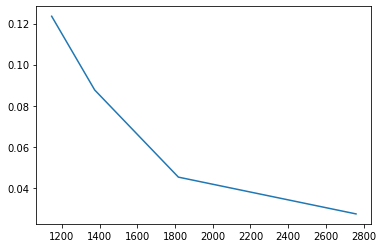

In [57]:
plt.plot([results_map[key][0] for key in results_map.keys()],[results_map[key][1] for key in results_map.keys()])

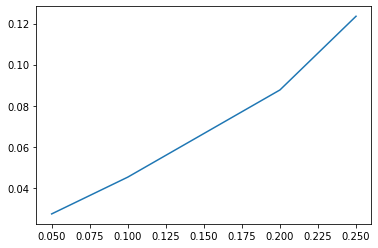

In [63]:
plt.plot([key for key in results_map.keys()],[results_map[key][1] for key in results_map.keys()])

In [61]:
results_map.keys()

dict_keys([0.05, 0.1, 0.2, 0.25])

In [23]:
#Evaluation 1.2: Histogram alone

In [24]:
#create one system to evaluate histograms
total_allowed_space = .1
histogram_min_size = .01
system_1 = AQP_system(data, numeric_columns, categorical_columns, total_allowed_space, histogram_min_size=histogram_min_size)


Total Size160000
Remaining Space16000.0


In [82]:
#Evaluate
n_examples = 100
columns_to_test = np.random.choice (numeric_columns, n_examples, replace = True)
cur_range = .5
sizes= [.01, .05, .1, .2, .25]

In [83]:
results_map= {}
for min_size in sizes:
    #size, total error, max error
    results_map[min_size] = [0, 0, 0]
    system_h = AQP_system(data, numeric_columns, categorical_columns, total_allowed_space, histogram_min_size=min_size)
    results_map[min_size][0] = system_h.get_histogram_size()
    total_error = 0
    total_max_error = 0
    for i in range (n_examples):
        column = columns_to_test[i]
        value = np.quantile (data[column].to_numpy(), cur_range)
        query = ['Range', column, value]
        result = system_h.approximate_query(query)
        estimate = result[0]
    
        #actual count above cur_range
        actual = (1-cur_range)*len(data[column].to_numpy())
        inc_error = abs((actual-estimate)/len(data[column].to_numpy()))
        max_error = result[1]/len(data[column].to_numpy())

        total_error += inc_error
        total_max_error += max_error
    total_error = total_error/n_examples
    total_max_error = total_max_error/n_examples
    results_map[min_size][1] = total_error
    results_map[min_size][2] = total_max_error
    

Total Size160000
Remaining Space16000.0
Total Size160000
Remaining Space16000.0
Total Size160000
Remaining Space16000.0
Total Size160000
Remaining Space16000.0
Total Size160000
Remaining Space16000.0


In [84]:
#minimum size:[size, total errror, max error]
print(results_map)

{0.01: [500.0, 0.033968000000000026, 0.05223799999999998], 0.05: [2500.0, 0.03377600000000003, 0.051973999999999985], 0.1: [5000.0, 0.03374000000000002, 0.05193799999999997], 0.2: [10000.0, 0.03374000000000002, 0.05191399999999999], 0.25: [12500.0, 0.03374000000000002, 0.07664199999999997]}


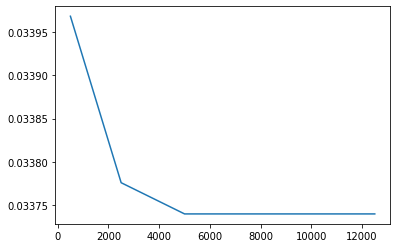

In [85]:
plt.plot([results_map[key][0] for key in results_map.keys()],[results_map[key][1] for key in results_map.keys()])

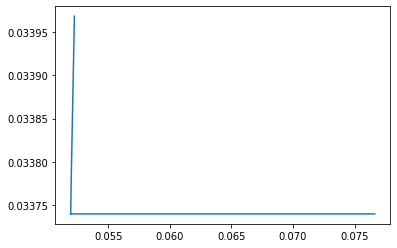

In [86]:
plt.plot([results_map[key][2] for key in results_map.keys()],[results_map[key][1] for key in results_map.keys()])

In [70]:
[key for key in results_map.keys()]

[0.01, 0.05, 0.1, 0.15, 0.2]

In [ ]:
#Evaluation 1.3: Sum+Predicate alone

In [87]:
#create one system to evaluate Sum+Predicate
total_allowed_space = .1
sample_error = .1
system_1 = AQP_system(data, numeric_columns, categorical_columns, total_allowed_space, sample_error=sample_error)

Total Size160000
Remaining Space16000.0


In [88]:
#Evaluate
n_examples = 100
numeric_columns_to_test = np.random.choice (numeric_columns, n_examples, replace = True)
categorical_columns_to_test =  np.random.choice (categorical_columns, n_examples, replace = True)
errors = [.1, .2, .3, .4, .5]

In [89]:
results_map= {}
for error in errors:
    #actual eror, size
    results_map[error] = [0, 0]
    system_s = AQP_system(data, numeric_columns, categorical_columns, total_allowed_space, sample_error=error)
    results_map[error][0] = system_s.get_measure_biased_samples_size();
    total_error = 0
    for i in range (n_examples):
        numeric_column = numeric_columns_to_test[i]
        categorical_column = categorical_columns_to_test[i]

        query = ['Sum+Predicate', numeric_column, categorical_column]
        estimated_distribution = system_s.approximate_query(query)

        #actual distribution
        total_actual = 0
        actual_distribution = {}
        for predicate in data[categorical_column]:
            if (predicate not in actual_distribution):
                actual_distribution[predicate] = 1
            else:  
                actual_distribution[predicate] += 1
            total_actual += 1
        for key in actual_distribution:
            actual_distribution[key] /= total_actual

        inc_error = 0
        for key in actual_distribution:
            inc_error += (actual_distribution[key]-estimated_distribution[key])**2
        total_error += inc_error
    total_error = total_error/n_examples
    results_map[error][1] = total_error

Total Size160000
Remaining Space16000.0
Total Size160000
Remaining Space16000.0
Total Size160000
Remaining Space16000.0
Total Size160000
Remaining Space16000.0
Total Size160000
Remaining Space16000.0


In [90]:
print (results_map)

{0.1: [799920, 8.064167921140758e-05], 0.2: [199920, 0.00026362640249348227], 0.3: [88880, 0.0007171312392985289], 0.4: [49920, 0.0009376897351742271], 0.5: [32000, 0.0013551531999999988]}


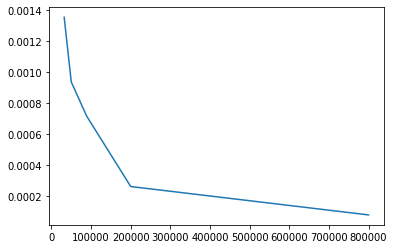

In [91]:
plt.plot([results_map[key][0] for key in results_map.keys()],[results_map[key][1] for key in results_map.keys()])

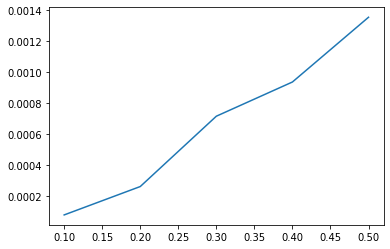

In [92]:
plt.plot([key for key in results_map.keys()],[results_map[key][1] for key in results_map.keys()])

In [ ]:
#analyze budget size based on e for samples
N = 10000
e = .1
print(int(math.sqrt(N)/(e**2)))

In [ ]:
#generate random workload
query_types = ['Stdev', 'Sum', 'Sum+Predicate', 'Quantile', 'Range', 'Count']
random_workload = np.random.choice(query_types, 100)

In [ ]:
float(1/3)